In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, learning_curve
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, precision_recall_curve, auc

# Load and preprocess

In [2]:
df = pd.read_csv('./heart.csv').drop_duplicates()
X = df.drop('target', axis=1)
y = df['target']

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [4]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Decision Tree - Grid Search


In [5]:
dt_params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

dt_grid = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    dt_params,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)
dt_grid.fit(X_train, y_train)
dt_best = dt_grid.best_estimator_
print("Best Decision Tree Parameters:", dt_grid.best_params_)

Fitting 10 folds for each of 90 candidates, totalling 900 fits
Best Decision Tree Parameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2}


# Random Forest - Grid Search

In [6]:
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    rf_params,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)
rf_grid.fit(X_train, y_train)
rf_best = rf_grid.best_estimator_
print("Best Random Forest Parameters:", rf_grid.best_params_)

Fitting 10 folds for each of 216 candidates, totalling 2160 fits
Best Random Forest Parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}


# Model Evaluation

In [7]:
models = {
    'Decision Tree': dt_best, 
    'Random Forest': rf_best
}
for name, model in models.items():
    y_pred = model.predict(X_test)
    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred))
    print(f"{name} ROC-AUC: {roc_auc_score(y_test, y_pred):.3f}")


Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.79      0.75        28
           1       0.80      0.73      0.76        33

    accuracy                           0.75        61
   macro avg       0.75      0.76      0.75        61
weighted avg       0.76      0.75      0.75        61

Decision Tree ROC-AUC: 0.756

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.71      0.73        28
           1       0.76      0.79      0.78        33

    accuracy                           0.75        61
   macro avg       0.75      0.75      0.75        61
weighted avg       0.75      0.75      0.75        61

Random Forest ROC-AUC: 0.751


# ROC & Precision-Recall Curves

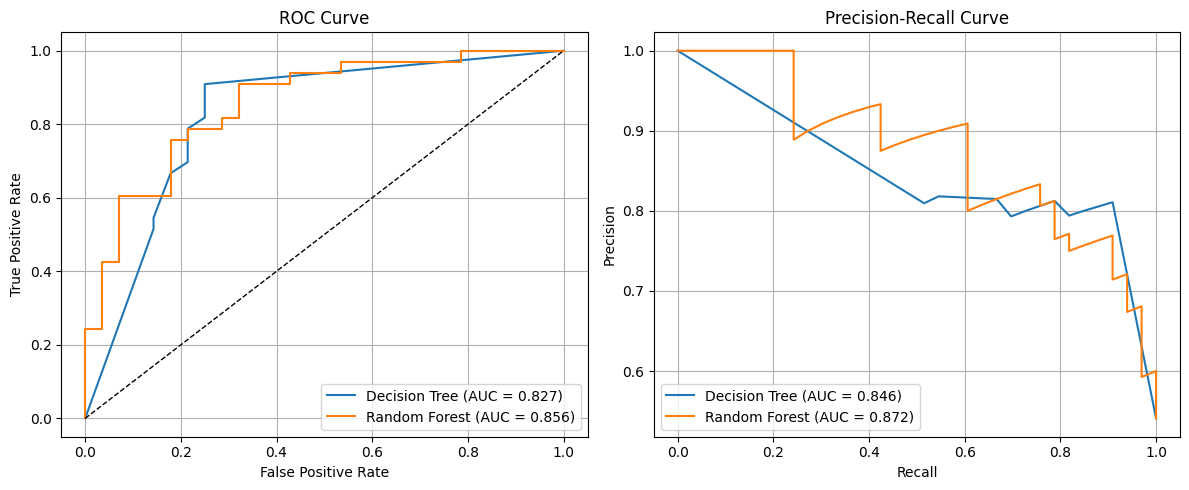

In [8]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
for name, model in models.items():
    y_probs = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)

plt.subplot(1, 2, 2)
for name, model in models.items():
    y_probs = model.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_probs)
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f"{name} (AUC = {pr_auc:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="lower left")
plt.grid(True)

plt.tight_layout()
plt.show()

# Visualize Decision Tree

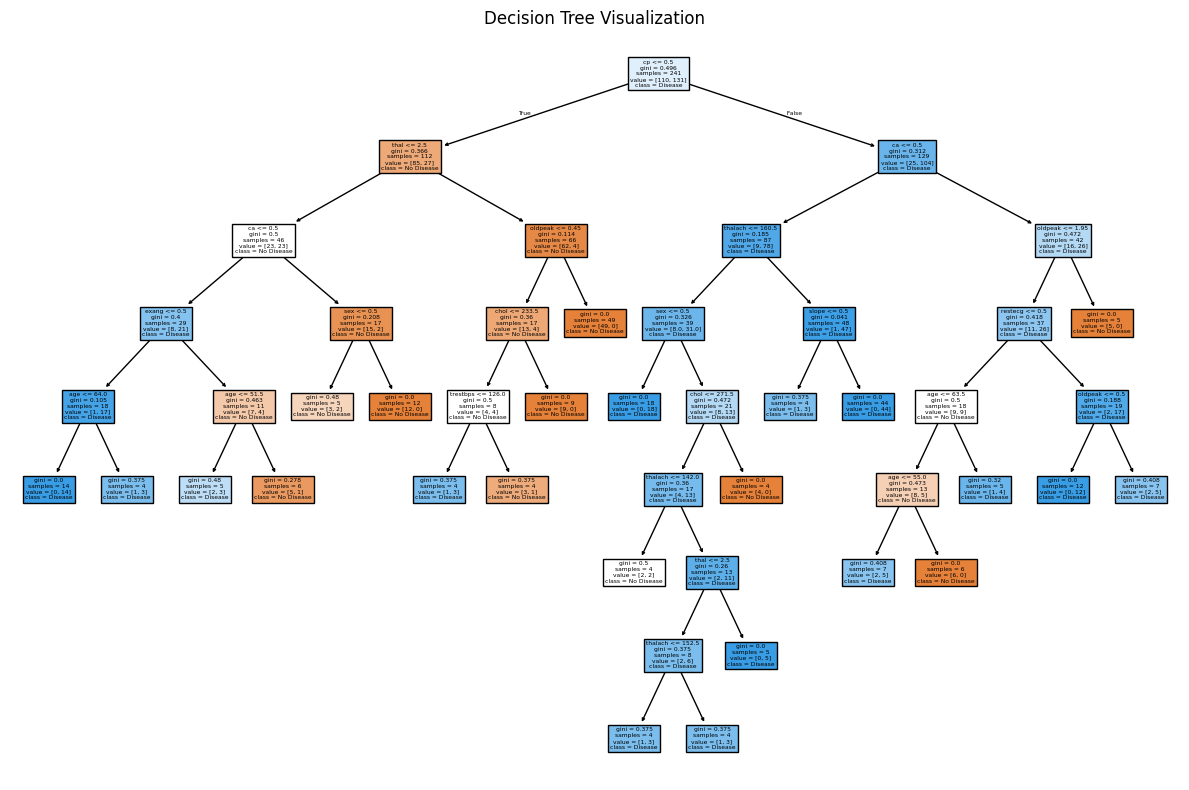

In [9]:
plt.figure(figsize=(12, 8))
plot_tree(dt_best, filled=True, feature_names=list(X.columns), class_names=['No Disease', 'Disease'])
plt.title('Decision Tree Visualization')
plt.tight_layout()
plt.show()

# Feature Importances

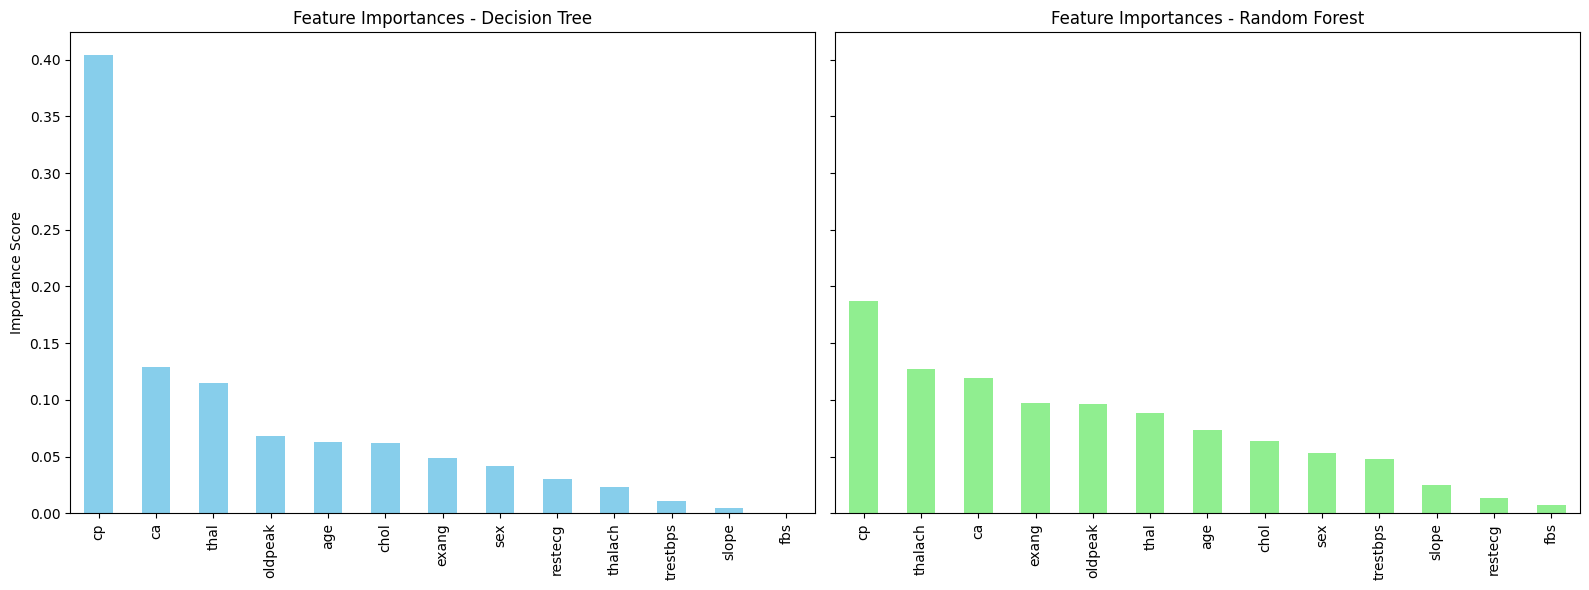

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
pd.Series(dt_best.feature_importances_, index=X.columns) \
    .sort_values(ascending=False) \
    .plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title("Feature Importances - Decision Tree")
axes[0].set_ylabel("Importance Score")

pd.Series(rf_best.feature_importances_, index=X.columns) \
    .sort_values(ascending=False) \
    .plot(kind='bar', ax=axes[1], color='lightgreen')
axes[1].set_title("Feature Importances - Random Forest")

plt.tight_layout()
plt.show()

# Learning Curves

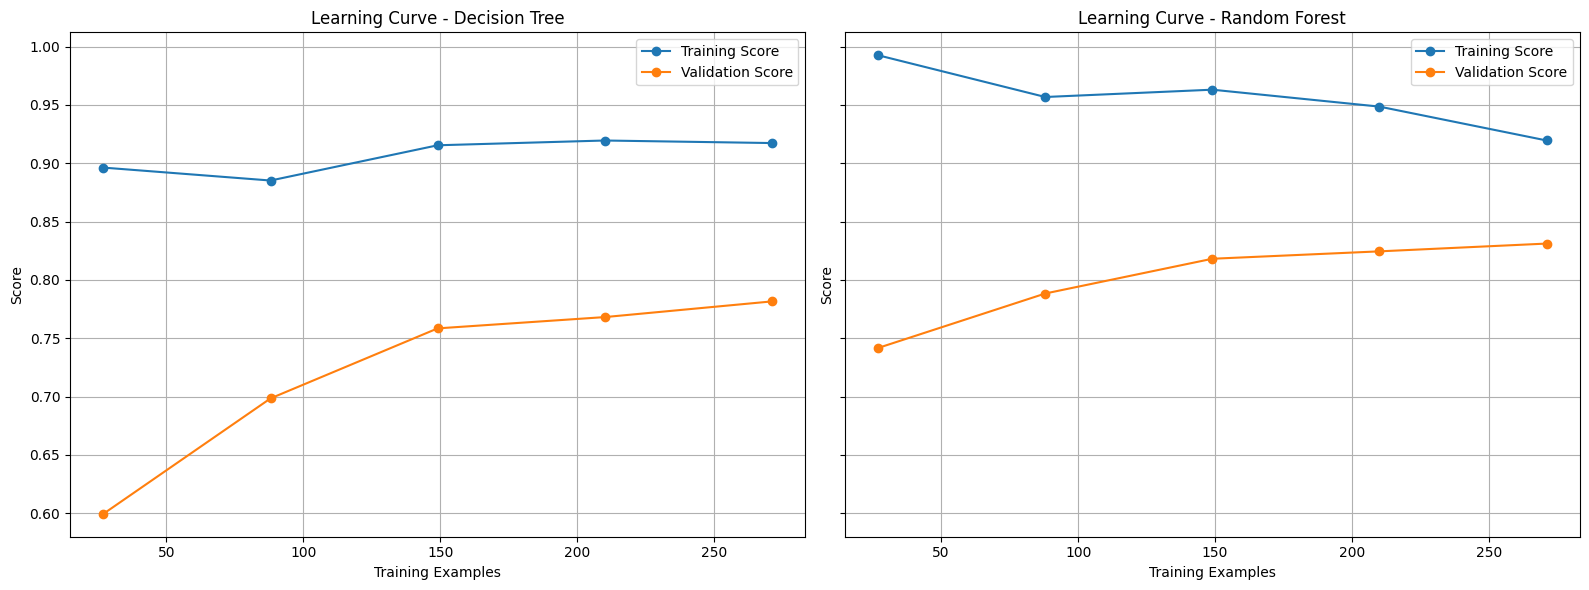

In [20]:
def plot_learning_curves_side_by_side(models, titles):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

    for ax, model, title in zip(axes, models, titles):
        train_sizes, train_scores, test_scores = learning_curve(
            model, X, y, cv=cv, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5)
        )
        ax.plot(train_sizes, train_scores.mean(axis=1), 'o-', label="Training Score")
        ax.plot(train_sizes, test_scores.mean(axis=1), 'o-', label="Validation Score")
        ax.set_title(title)
        ax.set_xlabel("Training Examples")
        ax.set_ylabel("Score")
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.show()
    
plot_learning_curves_side_by_side(
    [dt_best, rf_best],
    ["Learning Curve - Decision Tree", "Learning Curve - Random Forest"]
)

# CV Accuracy Comparison

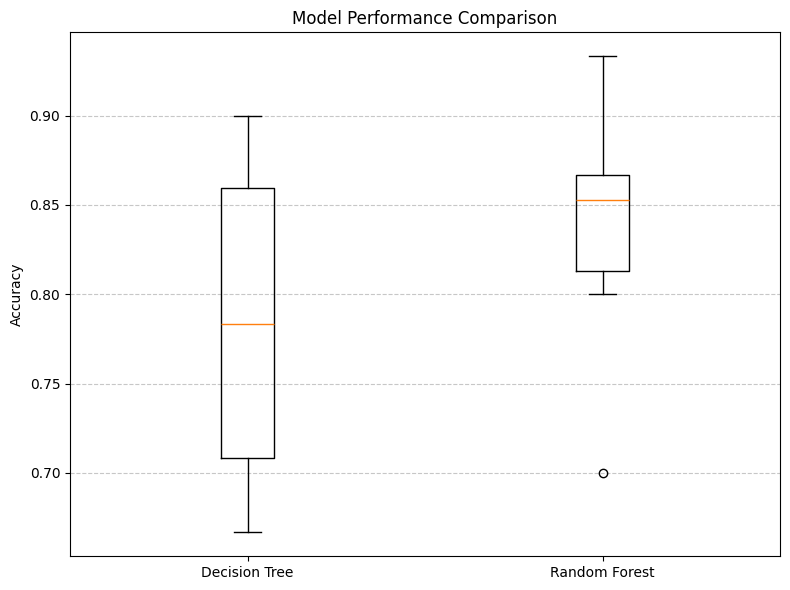

Decision Tree CV Accuracy: 0.785 ± 0.087
Random Forest CV Accuracy: 0.841 ± 0.061


In [15]:
dt_scores = cross_val_score(dt_best, X, y, cv=cv)
rf_scores = cross_val_score(rf_best, X, y, cv=cv)

plt.figure(figsize=(8, 6))
plt.boxplot([dt_scores, rf_scores], tick_labels=['Decision Tree', 'Random Forest'])
plt.title('Model Performance Comparison')
plt.ylabel('Accuracy')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print(f"Decision Tree CV Accuracy: {dt_scores.mean():.3f} ± {dt_scores.std():.3f}")
print(f"Random Forest CV Accuracy: {rf_scores.mean():.3f} ± {rf_scores.std():.3f}")